In [1]:
import numpy as np
import pandas as pd
import sys,os

def load_files(batch):
    images = []
    labels = []
    for i in batch:
        print('Loading File: ' + i)
        x = np.load(i).item()
        keys = x.keys()
        for key in keys:
            images.append(x[key][0])
            labels.append(x[key][1])
    return np.array(images),np.array(labels)

def get_feature(labels,feature):
    feature_values = []
    for i in labels:
        feature_values.append(i[feature])
    feature_values = np.array(feature_values)
    return feature_values

def get_cos_values(zenith,azimuth):
    cos1 = []
    cos2 = []
    cos3 = []
    for i,j in zip(zenith,azimuth):
        cos1.append(np.sin(i) * np.cos(j))
        cos2.append(np.sin(i) * np.sin(j))
        cos3.append(np.cos(i))
    return np.array(cos1),np.array(cos2),np.array(cos3)

In [2]:
file_path = '/fs/scratch/PAS1495/amedina/'
y = os.listdir(file_path+'processed_new')

file_names = []

for i in y:
    file_names.append(file_path+'processed_new/'+i)

file_names_batched = list(np.array_split(file_names,400))

In [3]:
images,labels = load_files(file_names_batched[0])

zenith_values = get_feature(labels,1)
azimuth_values = get_feature(labels,2)

cos1,cos2,cos3 = get_cos_values(zenith_values,azimuth_values)

Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_5958.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_207.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_5774.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_5256.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_4768.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_2519.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_4632.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_5356.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_4155.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_5633.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_4163.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_7039.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_6819.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_new/images_38

In [4]:
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , SeparableConv2D , GlobalAveragePooling2D, BatchNormalization
from keras import backend as K
from sklearn.model_selection import train_test_split,KFold
from keras.layers import LeakyReLU, PReLU
from keras import regularizers

Using TensorFlow backend.


In [5]:
cos_values = np.array(zip(cos1,cos2,cos3))

In [6]:
def get_data(images,true_values):
    x_train, x_test , y_train , y_test = train_test_split(images,true_values,test_size = 0.2 , random_state=42)
    x_train = x_train.reshape([x_train.shape[0],x_train.shape[1],x_train.shape[2],1])
    x_test = x_test.reshape([x_test.shape[0],x_test.shape[1],x_test.shape[2],1])
    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test = get_data(images,cos_values)

In [7]:
import itertools
import tensorflow as tf

sess = tf.Session()

def loss_space_angle(y_true,y_pred):
    subtraction = tf.math.subtract(y_true,y_pred)
    y = tf.matrix_diag_part(K.dot(subtraction,K.transpose(subtraction)))
    loss = tf.math.reduce_mean(y)
    return loss

y = loss_space_angle(y_train[0:166],y_test)
print(y.eval(session=sess))

1.5575252582720704


In [8]:
batch_size = 128
epochs=10

img_rows, img_cols = 300,342
input_shape = (img_rows, img_cols)

kernel = 3
kernel2 = 2

model = Sequential()
model.add(SeparableConv2D(32,kernel,
                          input_shape = (img_rows,img_cols,1),kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(SeparableConv2D(32,kernel,kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(SeparableConv2D(32,kernel,kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(MaxPooling2D(kernel2))

model.add(Dropout(0.25))

model.add(SeparableConv2D(32,kernel,kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(SeparableConv2D(32,kernel,kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(SeparableConv2D(32,kernel,kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(MaxPooling2D(kernel2))

model.add(Dropout(0.25))

model.add(SeparableConv2D(32,kernel,kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(SeparableConv2D(32,kernel,kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(SeparableConv2D(32,kernel,kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha = 0.01))
model.add(MaxPooling2D(kernel2))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32,activation='linear'))
model.add(LeakyReLU(alpha = 0.01))
model.add(Dense(3))


model.compile(optimizer='adam' , loss = loss_space_angle)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 664 samples, validate on 166 samples
Epoch 1/10
664/664 [==============================] - 28s 42ms/step - loss: 0.9128 - val_loss: 0.7823
Epoch 2/10
664/664 [==============================] - 27s 41ms/step - loss: 0.7774 - val_loss: 0.7711
Epoch 3/10
664/664 [==============================] - 27s 41ms/step - loss: 0.7600 - val_loss: 0.7640
Epoch 4/10
664/664 [==============================] - 27s 41ms/step - loss: 0.7704 - val_loss: 0.7585
Epoch 5/10
664/664 [==============================] - 27s 41ms/step - loss: 0.7599 - val_loss: 0.7571
Epoch 6/10
664/664 [==============================] - 26s 40ms/step - loss: 0.7587 - val_loss: 0.7537
Epoch 7/10
664/664 [==============================] - 27s 40ms/step - loss: 0.7598 - val_loss: 0.7562
Epoch 8/10
664/664 [==============================] - 27s 40ms/step - loss: 0.7594 - val_loss: 0.7630
Epoch 9/10
664/664 [==============================] - 26s 40ms/step - loss: 0.7596 - val_loss: 0.7541
Epoch 10/10
664/664 [===============

['loss', 'val_loss']


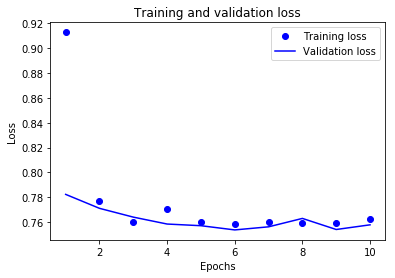

In [13]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()